In [2]:
import KoopmanAE

import os
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.cuda
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


# Auxilary functions

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def rescale(im, minim=None, maxim=None):
    if maxim is None :
      maxim = np.amax(im)
    if minim is None :
      minim = np.amin(im)
    return (im-minim)/(maxim-minim)

# Data importation and preprocessing

The data is publicly available on this Google Drive folder: https://drive.google.com/drive/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH?usp=sharing

One way to get it is to simply download it from there, possibly put it on your own drive and then upload it in your Colab session.

Alternatively, you can directly transfer the files from the folder to this session using the "gdown" command, as shown below:


In [4]:
data = np.load('data/Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [5]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [6]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [7]:
data_test = np.load('data/Orléans_irregular.npy')
mask_test = np.load('data/Orléans_irregular_mask.npy')

In [8]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 1:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [9]:
# This code snippet is just there to get the right format to display dates on the x-axis when plotting time series

from datetime import date, timedelta
import matplotlib.dates as mdates

date_zero = date.fromisoformat('2018-02-25')
print(date_zero)

five_days = timedelta(days=5)

dates = [date_zero]
for date in range(data.shape[0]-1) :
  dates.append(dates[-1] + five_days)
print(dates)

2018-02-25
[datetime.date(2018, 2, 25), datetime.date(2018, 3, 2), datetime.date(2018, 3, 7), datetime.date(2018, 3, 12), datetime.date(2018, 3, 17), datetime.date(2018, 3, 22), datetime.date(2018, 3, 27), datetime.date(2018, 4, 1), datetime.date(2018, 4, 6), datetime.date(2018, 4, 11), datetime.date(2018, 4, 16), datetime.date(2018, 4, 21), datetime.date(2018, 4, 26), datetime.date(2018, 5, 1), datetime.date(2018, 5, 6), datetime.date(2018, 5, 11), datetime.date(2018, 5, 16), datetime.date(2018, 5, 21), datetime.date(2018, 5, 26), datetime.date(2018, 5, 31), datetime.date(2018, 6, 5), datetime.date(2018, 6, 10), datetime.date(2018, 6, 15), datetime.date(2018, 6, 20), datetime.date(2018, 6, 25), datetime.date(2018, 6, 30), datetime.date(2018, 7, 5), datetime.date(2018, 7, 10), datetime.date(2018, 7, 15), datetime.date(2018, 7, 20), datetime.date(2018, 7, 25), datetime.date(2018, 7, 30), datetime.date(2018, 8, 4), datetime.date(2018, 8, 9), datetime.date(2018, 8, 14), datetime.date(2018

# Data visualisation

Pixel: (444, 119)
Spectral band: 5


Text(0.5, 0, 'date')

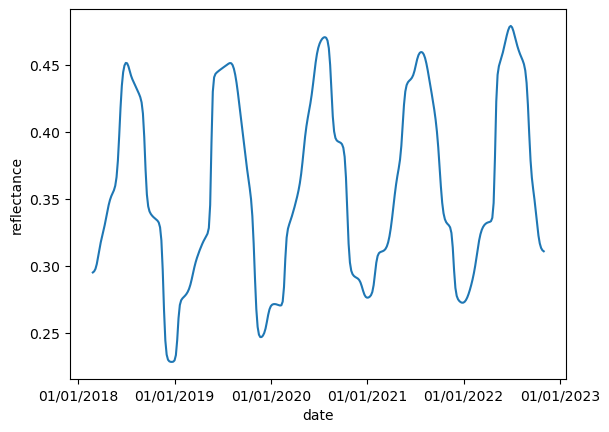

In [10]:
#Visualise the temporal evolution of one random spectral band from one random pixel
random_pixel = (rd.randint(0, data.shape[2]-1), rd.randint(0, data.shape[3]-1))
band = rd.randint(0, data.shape[1]-1)

print(f"Pixel: {random_pixel}")
print(f"Spectral band: {band}")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, data[:,band,random_pixel[0], random_pixel[1]])
plt.ylabel('reflectance')
plt.xlabel('date')

Pixel: (401, 250)


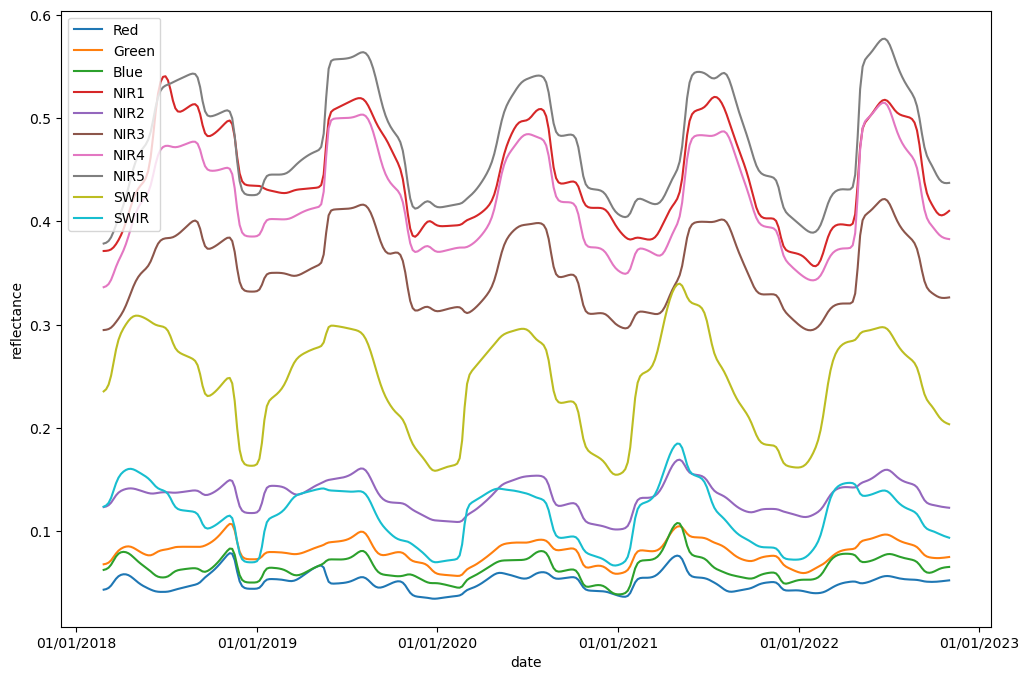

In [11]:
# Visualise the temporal evolution of all spectral bands from a random pixel
random_pixel = (rd.randint(0, data.shape[2]-1), rd.randint(0, data.shape[3]-1))
print(f"Pixel: {random_pixel}")
plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, data[:,:,random_pixel[0], random_pixel[1]])
plt.ylabel('reflectance')
plt.xlabel('date')
plt.legend(['Red', 'Green', 'Blue', 'NIR1', 'NIR2', 'NIR3', 'NIR4', 'NIR5', 'SWIR', 'SWIR']) # Those are the different spectral bands, in the order with this data form. More info on the spectral bands used here: https://gisgeography.com/sentinel-2-bands-combinations/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of data_viz : (343, 500, 500, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


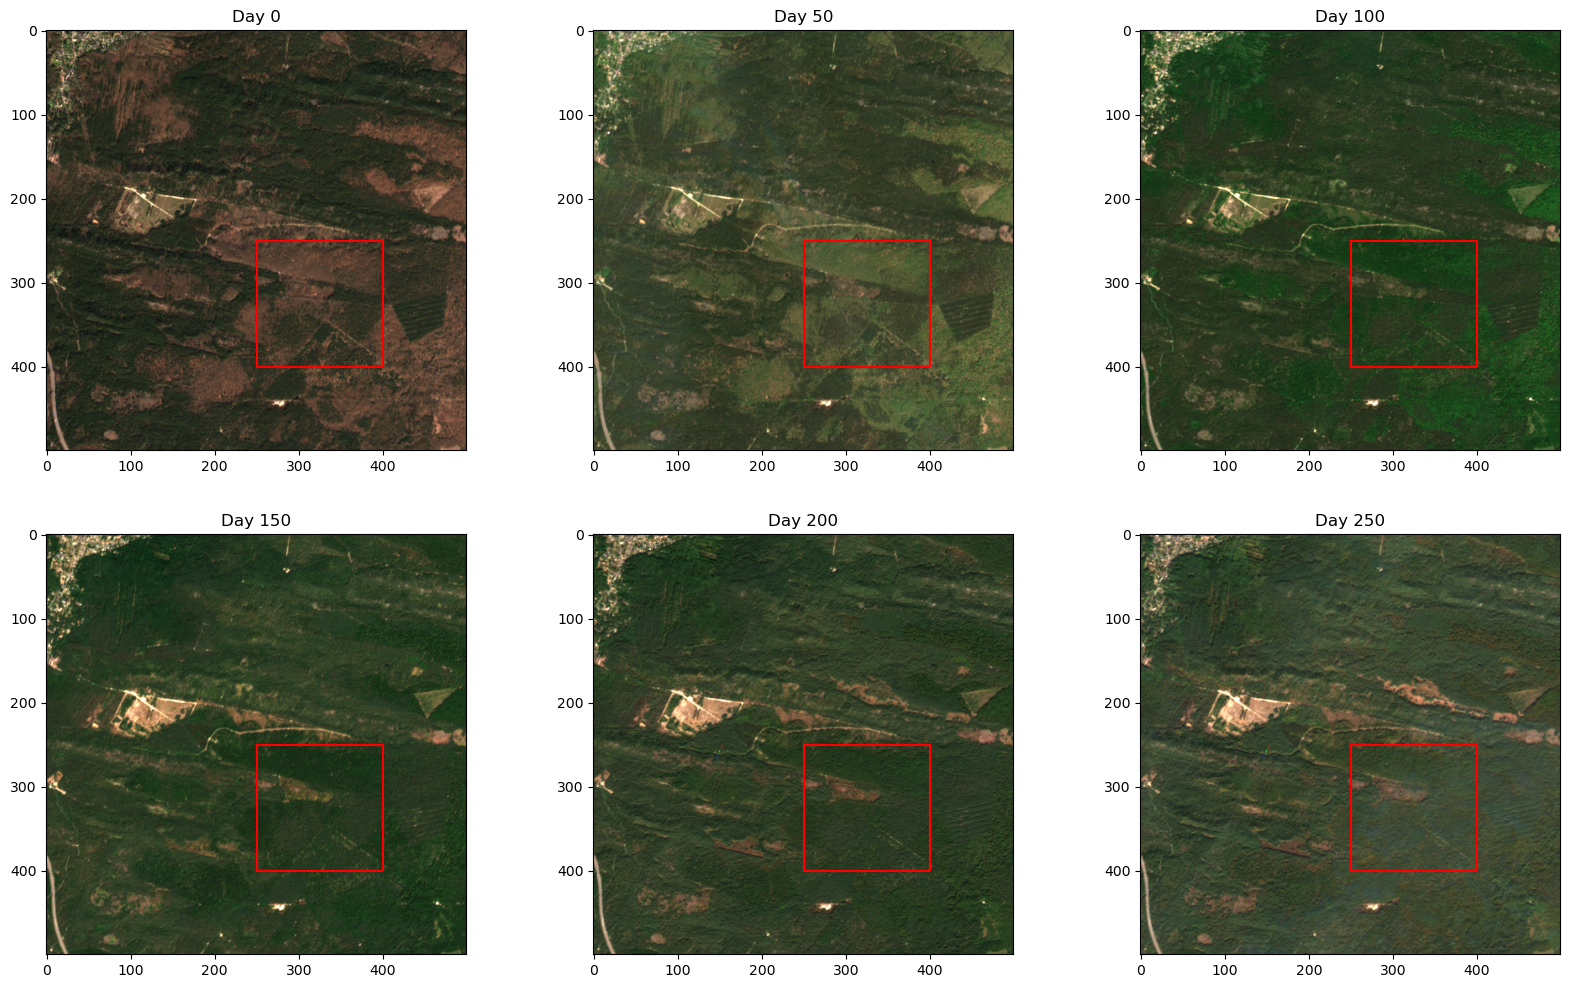

In [12]:
# Fontainebleau images
data_viz = (data[:,[2,1,0],:,:].transpose((0,2,3,1)))
print(f"Shape of data_viz : {data_viz.shape}")

times = [0,10,20,30,40,50]

plt.figure(figsize=(20,12))

for i in range(len(times)):
  plt.subplot(2,3,i + 1 )
  plt.imshow(data_viz[times[i]]*3) # 3 for visualisation purposes
  plt.title(f'Day {times[i]*5}') # 1 sample every 5 days
  plt.plot(np.arange(250,400),250*np.ones(150),'r')
  plt.plot(np.arange(250,400),400*np.ones(150),'r')
  plt.plot(250*np.ones(150),np.arange(250,400),'r')
  plt.plot(400*np.ones(150),np.arange(250,400),'r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


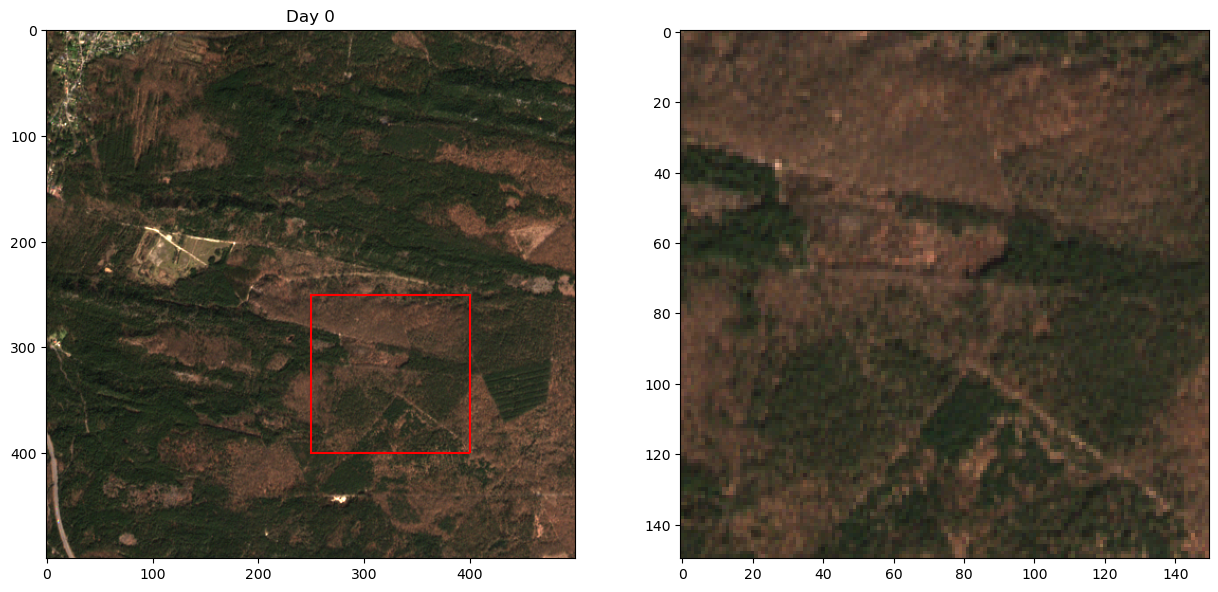

In [13]:
data_small = data[:,:,250:400,250:400].transpose((0,2,3,1)) # we use a smaller crop to reduce the computational burden

plt.figure(figsize =(15,7.5))
plt.subplot(121)
plt.imshow(data_viz[times[0]]*3)
plt.title(f'Day {times[0]*5}')
plt.plot(np.arange(250,400),250*np.ones(150),'r')
plt.plot(np.arange(250,400),400*np.ones(150),'r')
plt.plot(250*np.ones(150),np.arange(250,400),'r')
plt.plot(400*np.ones(150),np.arange(250,400),'r')

data_crop_viz = data_small[:,:,:,[2,1,0]]

plt.subplot(122)
plt.imshow(data_crop_viz[times[0]]*3)

# Model loading

In [14]:
model = KoopmanAE.KoopmanAE(20, [512,256,32]).to(device)

print(count_parameters(model))

print(model)

300596
KoopmanAE(
  (encoder): ModuleList(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
)


In [15]:
model_path = 'Fontainebleau_trained_model.pt'
K_path = 'Fontainebleau_trained_K.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.K = torch.load(K_path, map_location=device)

# LSTM loading

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, future=0, n_steps=1):
        outputs = []
        batch_size = x.size(0)
        seq_len = x.size(1)
        h_t = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Iterate through time steps
        for i in range(future):
            #print(i)
            #print(x.shape, h_t.shape)
            out, (h_t, c_t) = self.lstm(x[:,-1:,:], (h_t, c_t))
            #print(out.shape)
            out = self.fc(out)
            outputs.append(out)
            #print(out.shape, x.shape)
            x = torch.cat((x, out), dim=1)

        outputs = torch.cat(outputs, dim=1)
        return outputs

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [18]:
LSTM = LSTMModel(20,256,20).to(device)
path = 'LSTM_trained_model.pt'
LSTM.load_state_dict(torch.load(path))

<All keys matched successfully>

# Prediction from an initial condition on Fontainebleau

## Visualise the prediction for a random pixel and spectral band

Pixel: (139, 54)
Band: 4


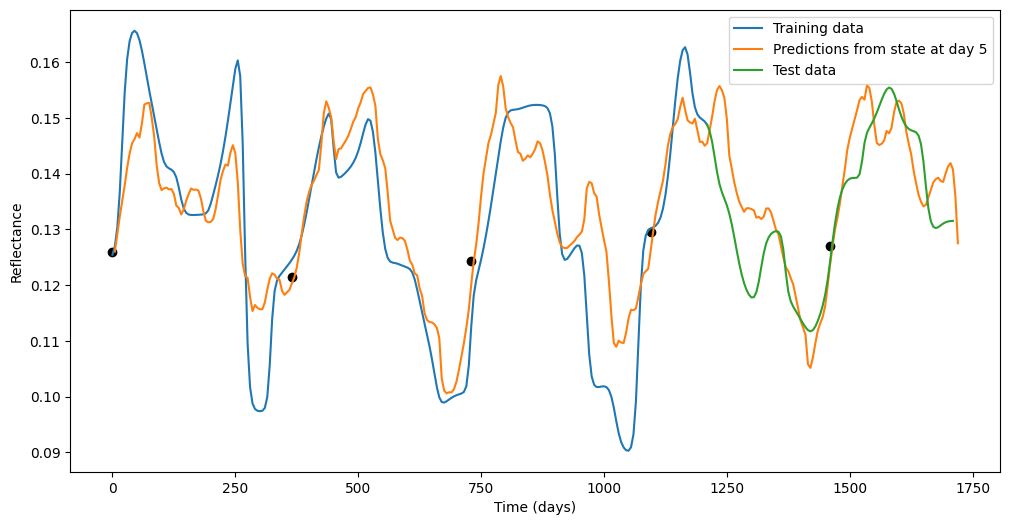

In [ ]:
time_span = 343
pixel = (rd.randint(0,149), rd.randint(0,149))
band = rd.randint(0,9)
print(f"Pixel: {pixel}")
print(f"Band: {band}")

initial_state = torch.Tensor(data_small[1,pixel[0],pixel[1],:]).to(device)
initial_state = torch.cat((initial_state, torch.Tensor(data_small[1,pixel[0],pixel[1],:] - data_small[0,pixel[0],pixel[1],:]).to(device)))
predictions = torch.Tensor(np.zeros_like(data_small)).to(device)
x_advanced, phis = model.forward_n_remember(initial_state, time_span)
predictions = model.decode(phis)

data_len = data_small.shape[0]
X = [5*k for k in range(1000)]
plt.figure(figsize=(12,6))
plt.xlabel('Time (days)')
plt.ylabel('Reflectance')
plt.plot(X[:data_len-100], data_small[:data_len-100,pixel[0],pixel[1],band],label='Training data')
plt.plot(X[1:time_span+2], predictions[:,band].cpu().detach(), label='Predictions from state at day 5')
plt.plot(X[data_len-101:data_len], data_small[data_len-101:,pixel[0],pixel[1],band],label='Test data')
X, Y = [], []
for k in range(time_span // 73 + 1) :
  X.append(73*k*5)
  Y.append(predictions[73*k, band].cpu().detach())
plt.scatter(X, Y, c='black')
plt.legend()

## Compute the MSE on all the data

In [ ]:
#time_span = 227
time_span = 341
steps = 4
L = 10
dim = 20
forward = 1
data_len = data_small.shape[0]
size = 100 # Area used for testing in the paper
# size = 150 # to get the results on the complete training area

initial_state_total = torch.Tensor(data_small[1,:size,:size]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(data_small[1,:size,:size] - data_small[0,:size,:size]).to(device)), dim=2)
print(initial_state_total.shape)
t0 = time()
predictions = torch.zeros((data_small.shape[0]-1,
                            size,
                            size,
                            data_small.shape[3]*2))#.to(device)
t0 = time()

for batch in range(predictions.shape[1]) :
  for k in range(steps) :
    batch_len = initial_state_total.shape[1]
    #print(initial_state_total.shape)
    x_advanced, phis = model.forward_n_remember(initial_state_total[batch,batch_len*k:batch_len*(k+1)], time_span)
    #print(model.decode(phis).cpu().detach().shape)
    #print(predictions.shape)
    predictions[:,batch,batch_len*k:batch_len*(k+1)] = model.decode(phis).cpu().detach()
print(f"Shape of predictions : {predictions.shape}")
print(f"Time for computing the predictions : {time()-t0}")
t0 = time()
MSE = torch.mean((predictions[:,:,:,:10] - torch.Tensor(data_small[1:,:size,:size])) **2).item()
ML1 = torch.mean(torch.abs(predictions[:,:,:,:10] - torch.Tensor(data_small[1:,:size,:size]))).item()
MSE_intra = torch.mean((predictions[:data_len-101,:,:,:10]
                        - torch.Tensor(data_small[1:data_len-100,:size,:size])) **2).item()
ML1_intra = torch.mean(torch.abs(predictions[:data_len-101,:,:,:10]
                                  - torch.Tensor(data_small[1:data_len-100,:size,:size]))).item()
MSE_extra = torch.mean((predictions[data_len-101:,:,:,:10]
                        - torch.Tensor(data_small[data_len-100:,:size,:size])) **2).item()
ML1_extra = torch.mean(torch.abs(predictions[data_len-101:,:,:,:10]
                                  - torch.Tensor(data_small[data_len-100:,:size,:size]))).item()
print(f"Time for computing the MSE and ML1 : {time()-t0}")
print(f"Mean squared error : {MSE}")
print(f"Mean L1 error : {ML1}")
print(f"Mean squared error (training) : {MSE_intra}")
print(f"Mean L1 error (training) : {ML1_intra}")
print(f"Mean squared error (extrapolation) : {MSE_extra}") # Result reported in the paper
print(f"Mean L1 error (extrapolation) : {ML1_extra}")
print(f"Shape of extrapolation : {predictions[:10,:,:,predictions.shape[3]-100:].shape}")

torch.Size([100, 100, 20])
Shape of predictions : torch.Size([342, 100, 100, 20])
Time for computing the predictions : 2.036926031112671
Time for computing the MSE and ML1 : 0.28310537338256836
Mean squared error : 0.0016710740746930242
Mean L1 error : 0.026387959718704224
Mean squared error (training) : 0.0014781522331759334
Mean L1 error (training) : 0.024783873930573463
Mean squared error (extrapolation) : 0.002137944335117936
Mean L1 error (extrapolation) : 0.03026985004544258
Shape of extrapolation : torch.Size([10, 100, 100, 20])


If you used size=100, the extrapolation MSE should be around 2.14e-3, which is the result reported in the paper.

# Assimilation-forecasting on a single pixel

In [ ]:
time_span = 241
# Predict for a random pixel
pixel = (rd.randint(0,149), rd.randint(0,149))

time_span = 241
initial_state_total = torch.Tensor(data_small[1,pixel[0],pixel[1],:]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(data_small[1,pixel[0],pixel[1],:] - data_small[0,pixel[0],pixel[1],:]).to(device)))
reflectances_cuda = torch.Tensor(data_small[:,pixel[0],pixel[1]]).to(device)
t0 = time()
print(reflectances_cuda.shape, predictions.shape)
print(initial_state_total.shape)
initial_latent_state = model.encode(initial_state_total)
initial_latent_state = torch.clone(initial_latent_state).detach()
initial_latent_state = initial_latent_state.requires_grad_()
epochs = 201
opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  phis = [initial_latent_state]
  for k in range(time_span) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis)
  #print(decoded.shape)
  loss = model.mse_loss(decoded[:,:10], reflectances_cuda[1:time_span+2])
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

torch.Size([343, 10]) torch.Size([342, 100, 100, 20])
torch.Size([20])
Epoch 0 : loss 0.02133508212864399
Epoch 10 : loss 0.003435433842241764
Epoch 20 : loss 0.002542501548305154
Epoch 30 : loss 0.001959469635039568
Epoch 40 : loss 0.0016087712720036507
Epoch 50 : loss 0.0014692896511405706
Epoch 60 : loss 0.001404372276738286
Epoch 70 : loss 0.001396136125549674
Epoch 80 : loss 0.001381962327286601
Epoch 90 : loss 0.001374663901515305
Epoch 100 : loss 0.0013682706048712134
Epoch 110 : loss 0.0013612076872959733
Epoch 120 : loss 0.0013523538364097476
Epoch 130 : loss 0.0013530970318242908
Epoch 140 : loss 0.001352051505818963
Epoch 150 : loss 0.001350770820863545
Epoch 160 : loss 0.0013512984151020646
Epoch 170 : loss 0.001351059414446354
Epoch 180 : loss 0.0013516404433175921
Epoch 190 : loss 0.0013504022499546409
Epoch 200 : loss 0.0013509925920516253


Pixel: (146, 107)
Band: 6


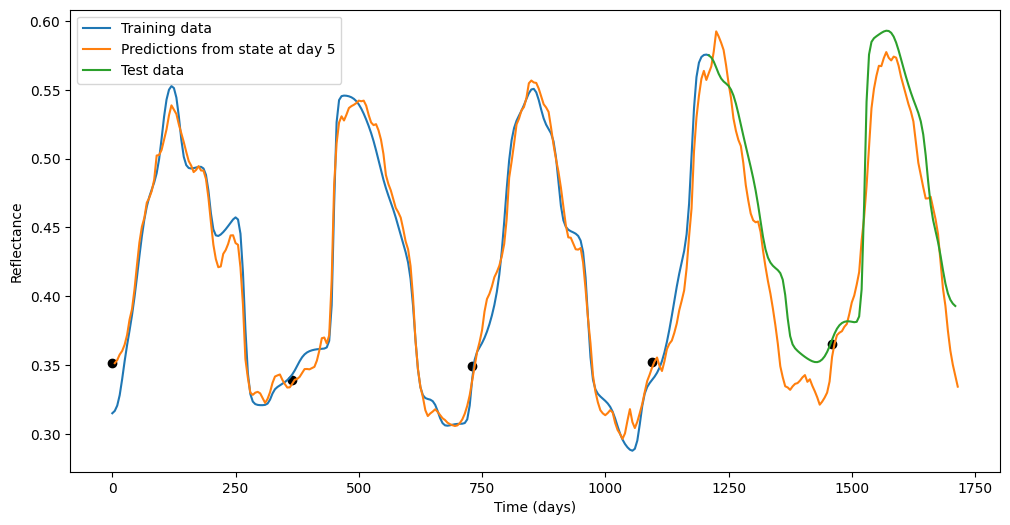

In [ ]:
phis = [initial_latent_state]
for k in range(data_small.shape[0]-1) :
  phis.append(model.one_step_ahead(phis[-1]))
phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
predictions = model.decode(phis)

band = rd.randint(0,9)
print(f"Pixel: {pixel}")
print(f"Band: {band}")
time_span = 343
data_len = data_small.shape[0]
X = [5*k for k in range(1000)]
plt.figure(figsize=(12,6))
plt.xlabel('Time (days)')
plt.ylabel('Reflectance')
plt.plot(X[:data_len-100], data_small[:data_len-100,pixel[0],pixel[1],band],label='Training data')
plt.plot(X[1:time_span+1], predictions[:,band].cpu().detach(), label='Predictions from state at day 5')
plt.plot(X[data_len-101:data_len], data_small[data_len-101:,pixel[0],pixel[1],band],label='Test data')
X, Y = [], []
for k in range(time_span // 73 + 1) :
  X.append(73*k*5)
  Y.append(predictions[73*k, band].cpu().detach())
plt.scatter(X, Y, c='black')
plt.legend()

# Assimilation-forecasting with spatial prior (GPU required)

In [23]:
# Constrained forecasting, with no Tikhonov spatial prior (alpha = 0)

size = 50 # Limit for 16GB of GPU memory
size = 100 # Limit for 40GB of GPU memory
time_span = 241
alpha = 0
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
t0 = time()
predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)

initial_latent_state = model.encode(initial_state_total)
initial_latent_state = torch.clone(initial_latent_state).detach()
initial_latent_state = initial_latent_state.requires_grad_()
epochs = 201
opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  phis = [initial_latent_state]
  for k in range(time_span) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis).T
  loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,1:time_span+2])
  diff_x = (decoded[:, 1:, :, :] - decoded[:, :-1, :, :]) **2
  diff_y = (decoded[:, :, 1:, :] - decoded[:, :, :-1, :]) **2
  loss += alpha * torch.mean(diff_x) # Since alpha is zero here, this has no influence
  loss += alpha * torch.mean(diff_y)
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

phis = [initial_latent_state]
for k in range(predictions.shape[-1]-1) :
  phis.append(model.one_step_ahead(phis[-1]))
phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
decoded = model.decode(phis).T
predictions[:,:,:,:] = decoded
print(f"Final test MSE : {torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)}")

<ipython-input-23-16763b0e5799>:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  decoded = model.decode(phis).T


Epoch 0 : loss 13683.4677734375
Epoch 10 : loss 1800.6187744140625
Epoch 20 : loss 1147.17041015625
Epoch 30 : loss 802.4046020507812
Epoch 40 : loss 610.8358764648438
Epoch 50 : loss 516.22412109375
Epoch 60 : loss 466.6065979003906
Epoch 70 : loss 438.3671569824219
Epoch 80 : loss 421.33544921875
Epoch 90 : loss 410.5650939941406
Epoch 100 : loss 403.2848205566406
Epoch 110 : loss 398.1424255371094
Epoch 120 : loss 394.3506164550781
Epoch 130 : loss 391.4954528808594
Epoch 140 : loss 389.25225830078125
Epoch 150 : loss 387.5035095214844
Epoch 160 : loss 386.125
Epoch 170 : loss 385.02471923828125
Epoch 180 : loss 384.093505859375
Epoch 190 : loss 383.3236389160156
Epoch 200 : loss 382.7056884765625
Final test MSE : 0.0007257547113113105


In [24]:
# Constrained forecasting, with a Tikhonov spatial prior (alpha > 0)

size = 50 # Limit for 16GB of GPU memory
size = 100 # Limit for 40GB of GPU memory
time_span = 241
alpha = 500000
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
t0 = time()
predictions_ = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)

initial_latent_state = model.encode(initial_state_total)
initial_latent_state = torch.clone(initial_latent_state).detach()
initial_latent_state = initial_latent_state.requires_grad_()
epochs = 201
opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  phis = [initial_latent_state]
  for k in range(time_span) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis).T
  loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,1:time_span+2])
  diff_x = (decoded[:, 1:, :, :] - decoded[:, :-1, :, :]) **2
  diff_y = (decoded[:, :, 1:, :] - decoded[:, :, :-1, :]) **2
  loss += alpha * torch.mean(diff_x)
  loss += alpha * torch.mean(diff_y)
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

phis = [initial_latent_state]
for k in range(predictions.shape[-1]-1) :
  phis.append(model.one_step_ahead(phis[-1]))
phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
decoded = model.decode(phis).T
predictions_[:,:,:,:] = decoded
print(f"Final test MSE : {torch.mean((predictions_[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)}")

Epoch 0 : loss 13931.4013671875
Epoch 10 : loss 1956.733642578125
Epoch 20 : loss 1285.397705078125
Epoch 30 : loss 933.279296875
Epoch 40 : loss 737.1168212890625
Epoch 50 : loss 643.0675048828125
Epoch 60 : loss 594.072021484375
Epoch 70 : loss 566.4046630859375
Epoch 80 : loss 550.082763671875
Epoch 90 : loss 539.726318359375
Epoch 100 : loss 532.8917236328125
Epoch 110 : loss 528.1643676757812
Epoch 120 : loss 524.737548828125
Epoch 130 : loss 522.1898193359375
Epoch 140 : loss 520.2350463867188
Epoch 150 : loss 518.6587524414062
Epoch 160 : loss 517.4751586914062
Epoch 170 : loss 516.5299682617188
Epoch 180 : loss 515.6723022460938
Epoch 190 : loss 515.0264892578125
Epoch 200 : loss 514.4505004882812
Final test MSE : 0.0007078291964717209


(88, 47)
0.00033000472467392683 0.00034809127100743353
0.0008076945669017732 0.0008861355017870665


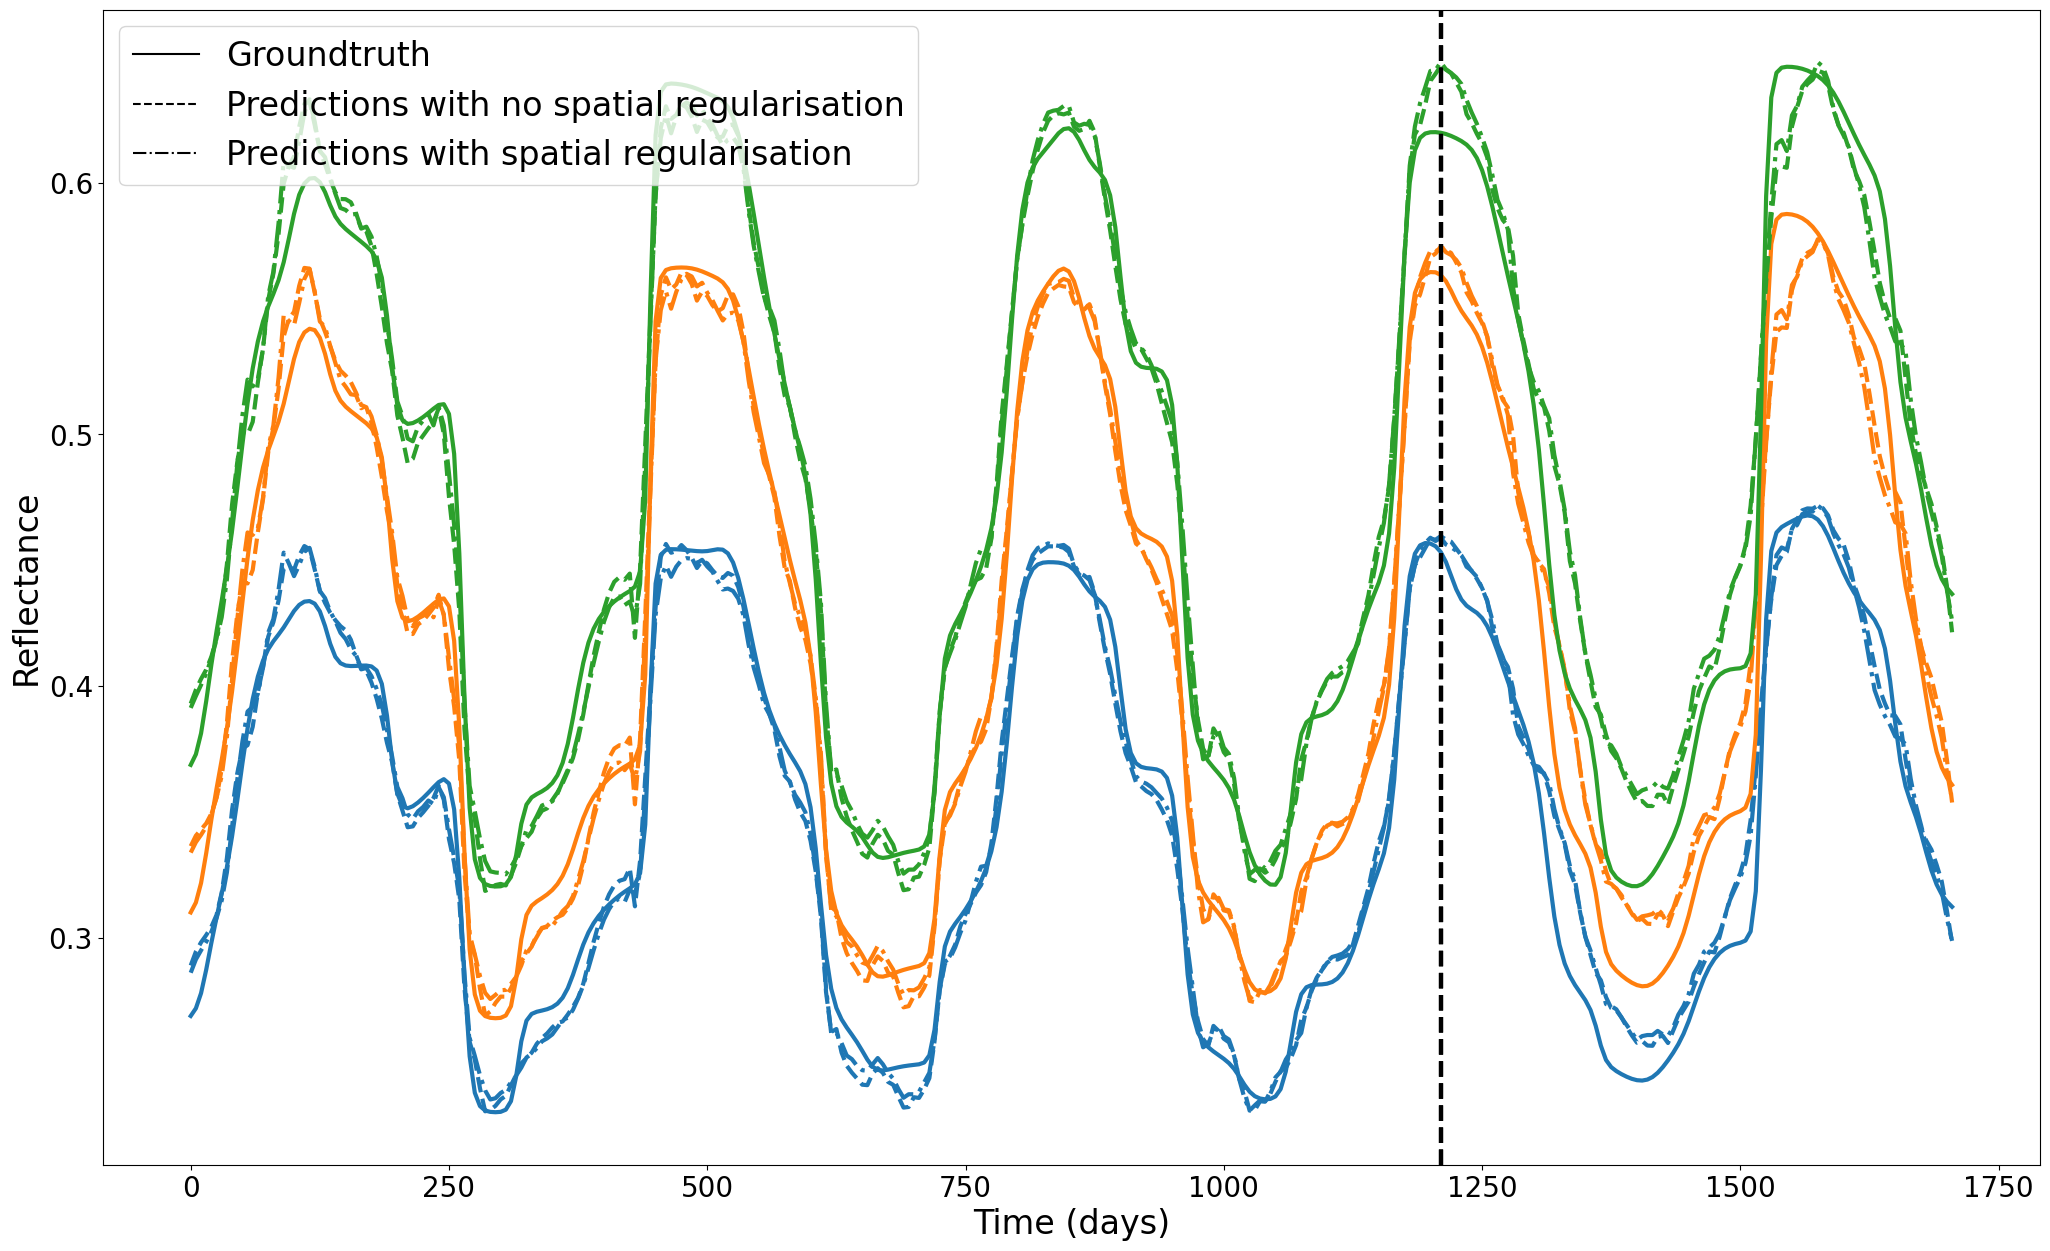

In [25]:
test_pixel = (rd.randint(0,size-1), rd.randint(0, size-1))
print(test_pixel)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
X = [5*k for k in range(reflectances.shape[3]-1)]
plt.figure(figsize=(25,15))
for band in range(5,8) :
  #plt.plot(reflectances[band,test_pixel[0],test_pixel[1],1:], c=colors[band], linewidth=2)
  #plt.plot(predictions[band,test_pixel[0],test_pixel[1],:], c=colors[band], linestyle='dashed', linewidth=2)

  plt.xlabel('Time (days)', size=24)
  plt.ylabel('Reflectance', size=24)
  plt.plot(X, reflectances[band,test_pixel[0],test_pixel[1],1:], c=colors[band-5], linewidth=3)
  plt.plot(X, predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach(), c=colors[band-5], linestyle='dashed', linewidth=3)
  plt.plot(X, predictions_[band,test_pixel[0],test_pixel[1],:].cpu().detach(), c=colors[band-5], linestyle='-.', linewidth=3)
  plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=3)
plt.plot([], [], c='black', label='Groundtruth')
plt.plot([], [], c='black', linestyle='dashed', label='Predictions with no spatial regularisation')
plt.plot([], [], c='black', linestyle='-.', label='Predictions with spatial regularisation')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.axes().set_xlim(X[0], X[-1])
plt.legend(fontsize=24)
#print((predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2)
print(torch.mean((predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2).item(),
      torch.mean((predictions_[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2).item())
print(torch.mean((predictions[band,test_pixel[0],test_pixel[1],242:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],243:]) **2).item(),
      torch.mean((predictions_[band,test_pixel[0],test_pixel[1],242:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],243:]) **2).item())

As reported in the paper, including a spatial prior in the loss function (alpha > 0) enables to get a lower final MSE.

# Reproduce the paper's figures (GPU with 40GB memory required)

In [17]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
t0 = time()
predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)

initial_latent_state = model.encode(initial_state_total)
initial_latent_state = torch.clone(initial_latent_state).detach()
initial_latent_state = initial_latent_state.requires_grad_()
epochs = 201
opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  phis = [initial_latent_state]
  for k in range(time_span) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis).T
  loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,1:time_span+2])
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

phis = [initial_latent_state]
for k in range(predictions.shape[-1]-1) :
  phis.append(model.one_step_ahead(phis[-1]))
phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
decoded = model.decode(phis).T
predictions[:,:,:,:] = decoded
print(f"Final test MSE : {torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)}")

<ipython-input-17-48569e013c49>:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  decoded = model.decode(phis).T


Epoch 0 : loss 13683.4677734375
Epoch 10 : loss 1800.6187744140625
Epoch 20 : loss 1147.17041015625
Epoch 30 : loss 802.4046020507812
Epoch 40 : loss 610.8358764648438
Epoch 50 : loss 516.22412109375
Epoch 60 : loss 466.6065979003906
Epoch 70 : loss 438.3671569824219
Epoch 80 : loss 421.33544921875
Epoch 90 : loss 410.5650939941406
Epoch 100 : loss 403.2848205566406
Epoch 110 : loss 398.1424255371094
Epoch 120 : loss 394.3506164550781
Epoch 130 : loss 391.4954528808594
Epoch 140 : loss 389.25225830078125
Epoch 150 : loss 387.5035095214844
Epoch 160 : loss 386.125
Epoch 170 : loss 385.02471923828125
Epoch 180 : loss 384.093505859375
Epoch 190 : loss 383.3236389160156
Epoch 200 : loss 382.7056884765625
Final test MSE : 0.0007257547113113105


In [18]:
# Constrained forecasting, with a Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory
time_span = 241
alpha = 1000000 # We use a value of alpha slightly higher than the optimal one, in order to make the differences more visible
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
t0 = time()
predictions_ = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)

initial_latent_state = model.encode(initial_state_total)
initial_latent_state = torch.clone(initial_latent_state).detach()
initial_latent_state = initial_latent_state.requires_grad_()
epochs = 201
opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  phis = [initial_latent_state]
  for k in range(time_span) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis).T
  loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,1:time_span+2])
  diff_x = (decoded[:, 1:, :, :] - decoded[:, :-1, :, :]) **2
  diff_y = (decoded[:, :, 1:, :] - decoded[:, :, :-1, :]) **2
  loss += alpha * torch.mean(diff_x)
  loss += alpha * torch.mean(diff_y)
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

phis = [initial_latent_state]
for k in range(predictions.shape[-1]-1) :
  phis.append(model.one_step_ahead(phis[-1]))
phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
decoded = model.decode(phis).T
predictions_[:,:,:,:] = decoded
print(f"Final test MSE : {torch.mean((predictions_[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)}")

Epoch 0 : loss 14179.333984375
Epoch 10 : loss 2087.74365234375
Epoch 20 : loss 1392.5892333984375
Epoch 30 : loss 1032.9068603515625
Epoch 40 : loss 834.5053100585938
Epoch 50 : loss 739.65869140625
Epoch 60 : loss 691.0201416015625
Epoch 70 : loss 663.57373046875
Epoch 80 : loss 647.5114135742188
Epoch 90 : loss 637.4593505859375
Epoch 100 : loss 630.8846435546875
Epoch 110 : loss 626.3684692382812
Epoch 120 : loss 623.0496826171875
Epoch 130 : loss 620.5973510742188
Epoch 140 : loss 618.6923217773438
Epoch 150 : loss 617.2099609375
Epoch 160 : loss 616.018798828125
Epoch 170 : loss 615.005615234375
Epoch 180 : loss 614.1888427734375
Epoch 190 : loss 613.5650024414062
Epoch 200 : loss 613.0140991210938
Final test MSE : 0.0007113447063602507


In [19]:
initial_time = 1
#initial_time = 242
time_span = 342 - initial_time
print(data_small.shape)
data_LSTM = data[:,:,250:250+size,250:250+size].transpose(0,2,3,1)
predictions_LSTM = torch.zeros(time_span,size,size,20, device='cpu')
print(predictions_LSTM.shape)

#input = torch.zeros(2048,20).to(device)
for batch in range(data_LSTM.shape[1]) :
  LSTM.eval()
  #print(batch)
  input = torch.zeros(data_LSTM.shape[2],20).to(device)
  #print(input.shape)
  input[:, :10] = torch.tensor(data_LSTM[initial_time,batch,:,:], device=device)
  input[:, 10:] = torch.tensor(data_LSTM[initial_time,batch,:,:]
                              - data_LSTM[initial_time-1,batch,:,:], device=device)

  prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
  #print(prediction.shape)
  predictions_LSTM[:,batch,:,:] = prediction.permute((1,0,2))

(343, 150, 150, 10)
torch.Size([341, 100, 100, 20])


(22, 44)
0.0007451839628629386 0.0006740153185091913
0.00172366201877594 0.0014369911514222622


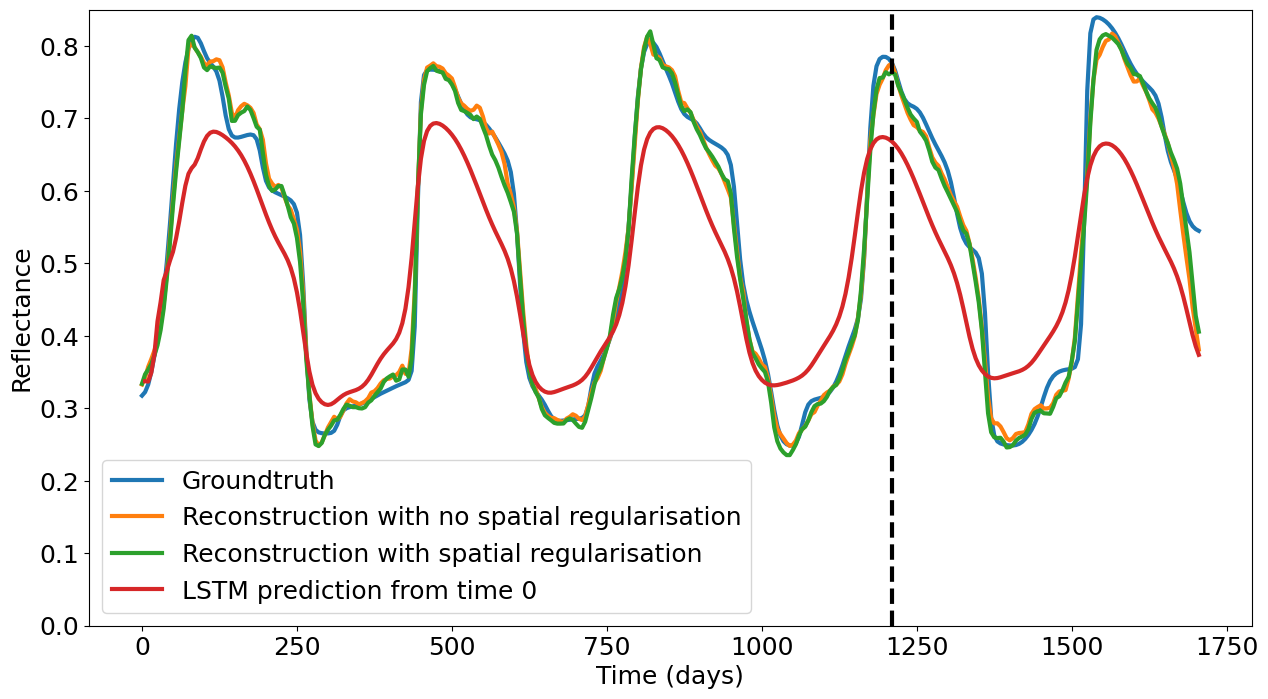

In [20]:
test_pixel = (22, 44) # Gives the figure from the paper
#test_pixel = (rd.randint(0,size-1), rd.randint(0, size-1)) # Uncomment to show the results for another pixel
X = [5*k for k in range(reflectances.shape[3]-1)]
print(test_pixel)

plt.figure(figsize=(15,8))
plt.ylim(0, 0.85)
for band in range(6,7) :
  #plt.plot(reflectances[band,test_pixel[0],test_pixel[1],1:], c=colors[band], linewidth=2)
  #plt.plot(predictions[band,test_pixel[0],test_pixel[1],:], c=colors[band], linestyle='dashed', linewidth=2)

  plt.xlabel('Time (days)', size=18)
  plt.ylabel('Reflectance', size=18)
  plt.plot(X, reflectances[band,test_pixel[0],test_pixel[1],1:], linewidth=3, label='Groundtruth')
  plt.plot(X, predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach(), linewidth=3, label='Reconstruction with no spatial regularisation')
  plt.plot(X, predictions_[band,test_pixel[0],test_pixel[1],:].cpu().detach(), linewidth=3, label='Reconstruction with spatial regularisation')
  plt.plot(X[1:], predictions_LSTM[:,test_pixel[0],test_pixel[1],band].cpu().detach(), linewidth=3, label='LSTM prediction from time 0')
  plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=3)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.axes().set_xlim(X[0], X[-1])
plt.legend(fontsize=18)
#print((predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2)
print(torch.mean((predictions[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2).item(),
      torch.mean((predictions_[band,test_pixel[0],test_pixel[1],:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],1:]) **2).item())
print(torch.mean((predictions[band,test_pixel[0],test_pixel[1],242:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],243:]) **2).item(),
      torch.mean((predictions_[band,test_pixel[0],test_pixel[1],242:].cpu().detach() - reflectances[band,test_pixel[0],test_pixel[1],243:]) **2).item())
plt.savefig('Assimilation-forecasting.pdf', bbox_inches='tight')

In [21]:
data_flat = torch.Tensor(reflectances[:,:size,:size,1:]).flatten(1,3).T
print(reflectances.shape, predictions.shape)
predictions_flat = predictions[:10].flatten(1,3).T.cpu().detach()
predictions_reg_flat = predictions_[:10].flatten(1,3).T.cpu().detach()

(10, 150, 150, 343) torch.Size([20, 100, 100, 342])


In [22]:
from sklearn.decomposition import PCA

pca = PCA(3)
pca.fit(data_flat)

PCA(n_components=3)

(3420000, 3)
-0.7757394841463651 0.9694059604859506
339
(100, 100, 342, 3)


Text(0.5, 1.0, 'PCA of the regularised prediction')

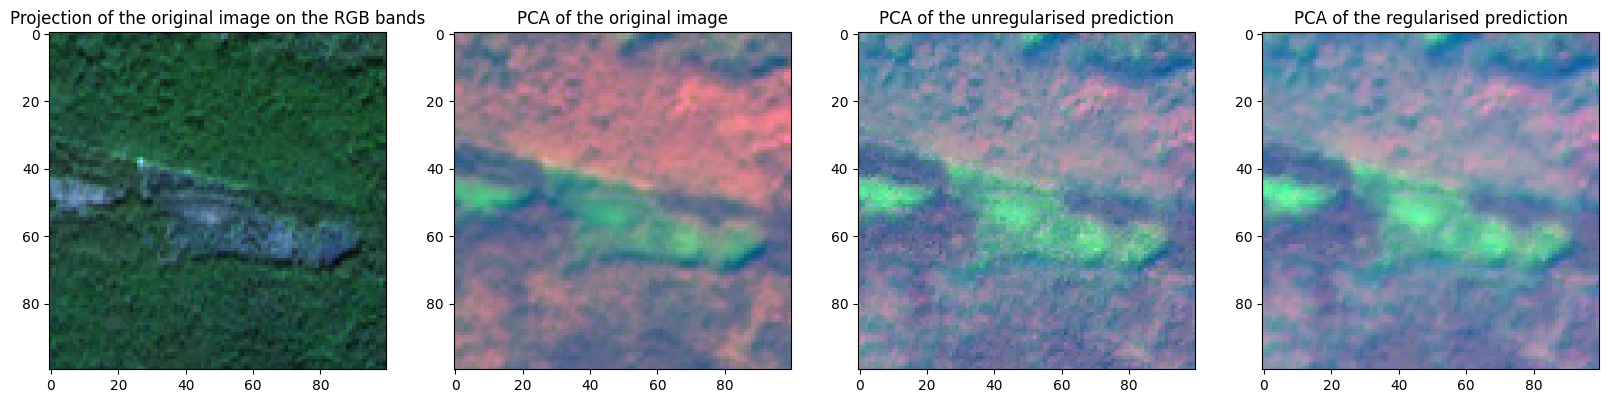

In [25]:
data_pca = pca.transform(data_flat)
print(data_pca.shape)
data_pca = data_pca.reshape((size, size, reflectances.shape[3]-1,3))
predictions_pca = pca.transform(predictions_flat).reshape((size, size, reflectances.shape[3]-1,3))
predictions_reg_pca = pca.transform(predictions_reg_flat).reshape((size, size, reflectances.shape[3]-1,3))
print(np.min(data_pca), np.max(data_pca))
#plt.imshow(data_pca[:,:,0,:])
time_ind = rd.randint(0,reflectances.shape[3]-2)
print(time_ind)
plt.figure(figsize=(20,8))
plt.subplot(141)
plt.imshow(rescale(reflectances[:3,:size,:size,time_ind]).transpose((1,2,0)))
plt.title("Projection of the original image on the RGB bands")
plt.subplot(142)
plt.imshow(rescale(data_pca[:,:,time_ind,:]))
plt.title("PCA of the original image")
plt.subplot(143)
print(predictions_pca.shape)
plt.imshow(rescale(predictions_pca[:,:,time_ind,:]))
plt.title("PCA of the unregularised prediction")
plt.subplot(144)
plt.imshow(rescale(predictions_reg_pca[:,:,time_ind,:]))
plt.title("PCA of the regularised prediction")

The regularised prediction is visually smoother than the unregularised one (it could be more easy to see depending on the random time index selected).

In [26]:
concat_pca = torch.column_stack((
    #torch.flatten(torch.Tensor(data_small_pca[1:]), 1),
     torch.flatten(torch.Tensor(data_pca).permute((0,1,3,2)), end_dim=2).T,
     torch.flatten(torch.Tensor(predictions_pca).permute((0,1,3,2)), end_dim=2).T,
     torch.flatten(torch.Tensor(predictions_reg_pca).permute((0,1,3,2)), end_dim=2).T)).numpy()
print(concat_pca.shape)
mins_pca = np.amin(concat_pca, axis=1)
maxs_pca = np.amax(concat_pca, axis=1)

(342, 90000)


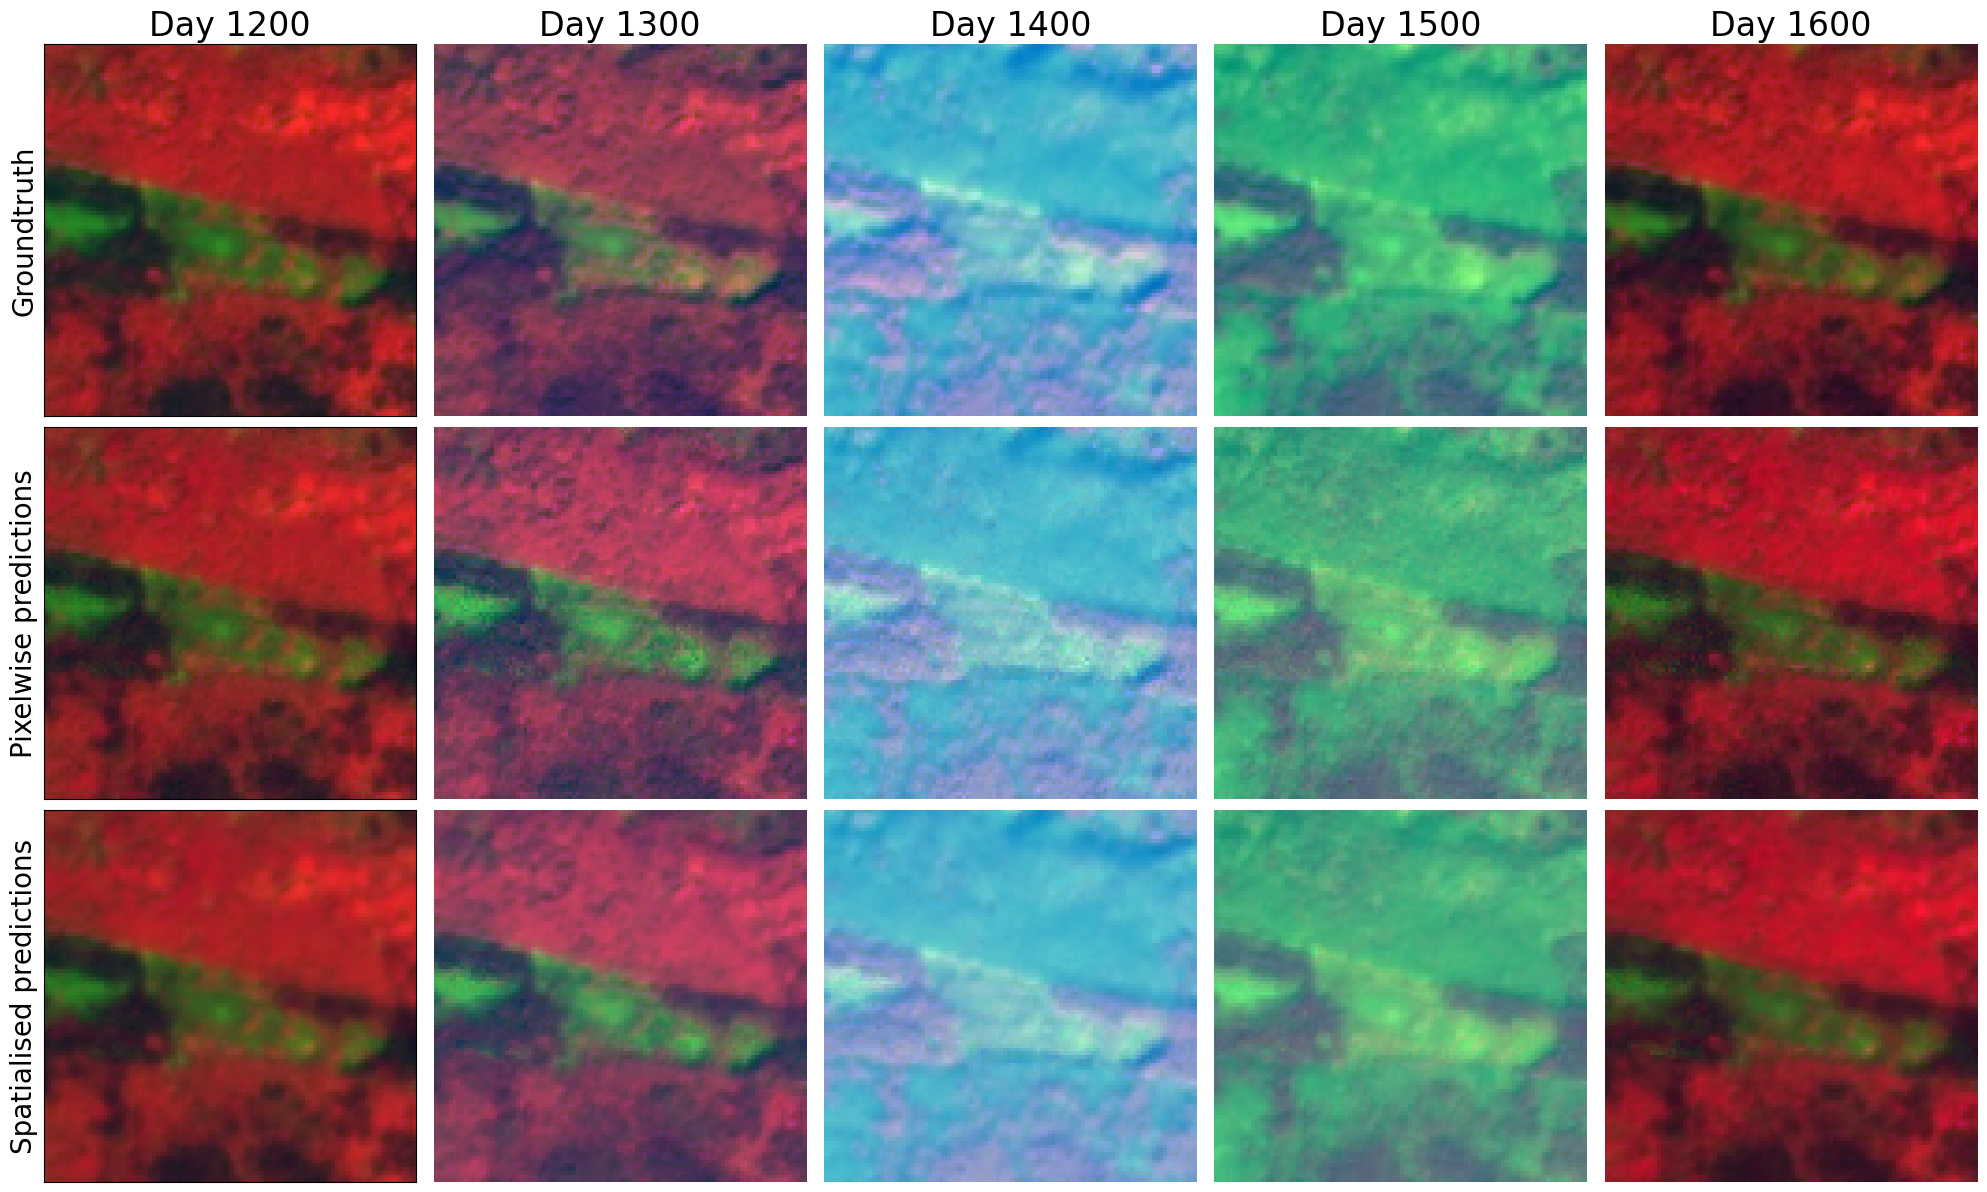

In [28]:
# All images on a given column share a common scale

times = [240, 260, 280, 300, 320] # Testing interval

cols = [f'Day {times[0]*5}', f'Day {times[1]*5}', f'Day {times[2]*5}', f'Day {times[3]*5}', f'Day {times[4]*5}']
rows = ['Groundtruth', 'Pixelwise predictions', 'Spatialised predictions']

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].set_title(cols[0], size=24)
axes[0,0].set_ylabel(rows[0], size=20)
axes[0,0].imshow(rescale(data_pca[:,:,times[0],:], mins_pca[times[0]], maxs_pca[times[0]]))
plt.subplot(352)
plt.axis('off')
plt.title(cols[1], size=24)
plt.imshow(rescale(data_pca[:,:,times[1],:], mins_pca[times[1]], maxs_pca[times[1]]))
plt.subplot(353)
plt.axis('off')
plt.title(cols[2], size=24)
plt.imshow(rescale(data_pca[:,:,times[2],:], mins_pca[times[2]], maxs_pca[times[2]]))
plt.subplot(354)
plt.axis('off')
plt.title(cols[3], size=24)
plt.imshow(rescale(data_pca[:,:,times[3],:], mins_pca[times[3]], maxs_pca[times[3]]))
plt.subplot(355)
plt.axis('off')
plt.title(cols[4], size=24)
plt.imshow(rescale(data_pca[:,:,times[4],:], mins_pca[times[4]], maxs_pca[times[4]]))

axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,0].set_ylabel(rows[1], size=20)
axes[1,0].imshow(rescale(predictions_pca[:,:,times[0],:], mins_pca[times[0]], maxs_pca[times[0]]))
plt.subplot(357)
plt.axis('off')
plt.imshow(rescale(predictions_pca[:,:,times[1],:], mins_pca[times[1]], maxs_pca[times[1]]))
plt.subplot(358)
plt.axis('off')
plt.imshow(rescale(predictions_pca[:,:,times[2],:], mins_pca[times[2]], maxs_pca[times[2]]))
plt.subplot(359)
plt.axis('off')
plt.imshow(rescale(predictions_pca[:,:,times[3],:], mins_pca[times[3]], maxs_pca[times[3]]))
plt.subplot(3,5,10)
plt.axis('off')
plt.imshow(rescale(predictions_pca[:,:,times[4],:], mins_pca[times[4]], maxs_pca[times[4]]))

axes[2,0].set_xticks([])
axes[2,0].set_yticks([])
axes[2,0].set_ylabel(rows[2], size=20)
axes[2,0].imshow(rescale(predictions_reg_pca[:,:,times[0],:], mins_pca[times[0]], maxs_pca[times[0]]))
plt.subplot(3,5,12)
plt.axis('off')
plt.imshow(rescale(predictions_reg_pca[:,:,times[1],:], mins_pca[times[1]], maxs_pca[times[1]]))
plt.subplot(3,5,13)
plt.axis('off')
plt.imshow(rescale(predictions_reg_pca[:,:,times[2],:], mins_pca[times[2]], maxs_pca[times[2]]))
plt.subplot(3,5,14)
plt.axis('off')
plt.imshow(rescale(predictions_reg_pca[:,:,times[3],:], mins_pca[times[3]], maxs_pca[times[3]]))
plt.subplot(3,5,15)
plt.axis('off')
plt.imshow(rescale(predictions_reg_pca[:,:,times[4],:], mins_pca[times[4]], maxs_pca[times[4]]))

fig.tight_layout()
plt.savefig('forecasting.pdf', bbox_inches='tight')